# TensorFlow Tutorial

Welcome to this week's programming assignment! Up until now, you've always used Numpy to build neural networks, but this week you'll explore a deep learning framework that allows you to build neural networks more easily. Machine learning frameworks like TensorFlow, PaddlePaddle, Torch, Caffe, Keras, and many others can speed up your machine learning development significantly. TensorFlow 2.3 has made significant improvements over its predecessor, some of which you'll encounter and implement here!

By the end of this assignment, you'll be able to do the following in TensorFlow 2.3:

* Use `tf.Variable` to modify the state of a variable
* Explain the difference between a variable and a constant
* Apply TensorFlow decorators to speed up code
* Train a Neural Network on a TensorFlow dataset

Programming frameworks like TensorFlow not only cut down on time spent coding, but can also perform optimizations that speed up the code itself. 

## 1 - Exploring the Tensorflow Library

To start, you will import the library:


In [28]:
import math
import numpy as np
import h5py
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.python.framework import ops
from tf_utils import load_dataset, random_mini_batches, convert_to_one_hot, predict

%matplotlib inline
np.random.seed(1)

Now that you have imported the library, we will walk you through its different applications. You will start with an example, where we compute for you the loss of one training example. 
$$loss = \mathcal{L}(\hat{y}, y) = (\hat y^{(i)} - y^{(i)})^2 \tag{1}$$

In [29]:
# tensorflow 2 running in eager mode by default

y_hat = tf.constant(36, name='y_hat')            # Define y_hat constant. Set to 36.
y = tf.constant(39, name='y')                    # Define y. Set to 39

loss = tf.Variable((y - y_hat)**2, name='loss')  # Create a variable for the loss
print(loss)

<tf.Variable 'loss:0' shape=() dtype=int32, numpy=9>


Writing and running programs in TensorFlow has the following steps:

1. Create Tensors (variables). 
2. Write operations between those Tensors.

Now let us look at an easy example. Run the cell below:

In [30]:
a = tf.constant(2)
b = tf.constant(10)
c = tf.multiply(a,b)
print(c)

tf.Tensor(20, shape=(), dtype=int32)


`@tf.function`: constructs a callable that executes a TensorFlow graph (`tf.Graph`) created by trace-compiling the TensorFlow operations in `func`, effectively executing `func` as a TensorFlow graph.

In [31]:
@tf.function
def double(x):
    return 2 * x

print(double(tf.constant(3)))

tf.Tensor(6, shape=(), dtype=int32)


The trace-compilation allows non-TensorFlow operations to execute, but under special conditions. In general, only TensorFlow operations are guaranteed to run and create fresh results whenever the GenericFunction is called. 

### 1.1 - Linear function

Lets start this programming exercise by computing the following equation: $Y = WX + b$, where $W$ and $X$ are random matrices and b is a random vector. 

**Exercise**: Compute $WX + b$ where $W, X$, and $b$ are drawn from a random normal distribution. W is of shape (4, 3), X is (3,1) and b is (4,1). As an example, here is how you would define a constant X that has shape (3,1):
```python
X = tf.constant(np.random.randn(3,1), name = "X")

```
Note that the difference between `tf.constant` and `tf.Variable` is that you can modify the state of a `tf.Variable` but cannot change the state of a `tf.constant`.

You might find the following functions helpful: 
- tf.matmul(..., ...) to do a matrix multiplication
- tf.add(..., ...) to do an addition
- np.random.randn(...) to initialize randomly


In [32]:
# GRADED FUNCTION: linear_function

def linear_function():
    """
    Implements a linear function: 
            Initializes W to be a random tensor of shape (4,3)
            Initializes X to be a random tensor of shape (3,1)
            Initializes b to be a random tensor of shape (4,1)
    Returns: 
    result -- runs the session for Y = WX + b 
    """
    
    np.random.seed(1)
    
    ### START CODE HERE ### (4 lines of code)
    X = tf.constant(np.random.randn(3, 1), name="X")
    W = tf.constant(np.random.randn(4, 3), name="W")
    b = tf.constant(np.random.randn(4, 1), name="b")
    Y = tf.add(tf.matmul(W, X), b, name="Y")
    ### END CODE HERE ### 

    return Y

In [33]:
print( "result = " + str(linear_function()))

result = tf.Tensor(
[[-2.15657382]
 [ 2.95891446]
 [-1.08926781]
 [-0.84538042]], shape=(4, 1), dtype=float64)


*** Expected Output ***: 

<table> 
<tr> 
<td>
**result**
</td>
<td>
[[-2.15657382]
 [ 2.95891446]
 [-1.08926781]
 [-0.84538042]]
</td>
</tr> 

</table> 

### 1.2 - Computing the sigmoid 
Great! You just implemented a linear function. Tensorflow offers a variety of commonly used neural network functions like `tf.sigmoid` and `tf.softmax`. For this exercise lets compute the sigmoid function of an input. 

In [34]:
# GRADED FUNCTION: sigmoid

def sigmoid(z):
    """
    Computes the sigmoid of z
    
    Arguments:
    z -- input value, scalar or vector
    
    Returns: 
    results -- the sigmoid of z
    """
    
    ### START CODE HERE ###
    x = tf.constant(z, tf.float32, name="x")
    # compute sigmoid(x)
    sigmoid = tf.sigmoid(x)
    ### END CODE HERE ###
    
    return sigmoid

In [35]:
print ("sigmoid(0) = " + str(sigmoid(0)))
print ("sigmoid(12) = " + str(sigmoid(12)))

sigmoid(0) = tf.Tensor(0.5, shape=(), dtype=float32)
sigmoid(12) = tf.Tensor(0.9999939, shape=(), dtype=float32)


*** Expected Output ***: 

<table> 
<tr> 
<td>
**sigmoid(0)**
</td>
<td>
0.5
</td>
</tr>
<tr> 
<td>
**sigmoid(12)**
</td>
<td>
0.999994
</td>
</tr> 

</table> 

### 1.3 -  Computing the Cost

You can also use a built-in function to compute the cost of your neural network. So instead of needing to write code to compute this as a function of $a^{[2](i)}$ and $y^{(i)}$ for i=1...m: 
$$ J = - \frac{1}{m}  \sum_{i = 1}^m  \large ( \small y^{(i)} \log a^{ [2] (i)} + (1-y^{(i)})\log (1-a^{ [2] (i)} )\large )\small\tag{2}$$

you can do it in one line of code in tensorflow!

**Exercise**: Implement the cross entropy loss. The function you will use is: 


- `tf.nn.sigmoid_cross_entropy_with_logits(logits = ...,  labels = ...)`

Your code should input `z`, compute the sigmoid (to get `a`) and then compute the cross entropy cost $J$. All this can be done using one call to `tf.nn.sigmoid_cross_entropy_with_logits`, which computes

$$- \frac{1}{m}  \sum_{i = 1}^m  \large ( \small y^{(i)} \log \sigma(z^{[2](i)}) + (1-y^{(i)})\log (1-\sigma(z^{[2](i)})\large )\small\tag{2}$$



In [36]:
# GRADED FUNCTION: cost

def cost(logits, labels):
    """
    Computes the cost using the sigmoid cross entropy
    
    Arguments:
    logits -- vector containing z, output of the last linear unit (before the final sigmoid activation)
    labels -- vector of labels y (1 or 0) 
    
    Note: What we've been calling "z" and "y" in this class are respectively called "logits" and "labels" 
    in the TensorFlow documentation. So logits will feed into z, and labels into y. 
    
    Returns:
    cost -- runs the session of the cost (formula (2))
    """
    
    ### START CODE HERE ### 
    z = tf.constant(logits, tf.float32, name="z")
    y = tf.constant(labels, tf.float32, name="y")
    # Use the loss function (approx. 1 line)
    cost = tf.nn.sigmoid_cross_entropy_with_logits(logits=z, labels=y)
    ### END CODE HERE ###
    
    return cost

In [37]:
logits = sigmoid(np.array([0.2, 0.4, 0.7, 0.9]))
cost = cost(logits, np.array([0, 0, 1, 1]))
print ("cost = " + str(cost))

cost = tf.Tensor([1.0053872  1.0366409  0.41385433 0.39956614], shape=(4,), dtype=float32)


** Expected Output** : 

<table> 
    <tr> 
        <td>
            **cost**
        </td>
        <td>
        [ 1.00538719  1.03664088  0.41385433  0.39956614]
        </td>
    </tr>

</table>

### 1.4 - Using One Hot encodings

Many times in deep learning you will have a y vector with numbers ranging from 0 to C-1, where C is the number of classes. If C is for example 4, then you might have the following y vector which you will need to convert as follows:


<img src="https://github.com/chtunsw/ml_notes/blob/master/dl_course/exercises/02%20Improving%20Deep%20Neural%20Networks%20Hyperparameter%20tuning%2C%20Regularization%20and%20Optimization/05/images/onehot.png?raw=1" style="width:600px;height:150px;">

This is called a "one hot" encoding, because in the converted representation exactly one element of each column is "hot" (meaning set to 1). To do this conversion in numpy, you might have to write a few lines of code. In tensorflow, you can use one line of code: 

- tf.one_hot(labels, depth, axis) 

**Exercise:** Implement the function below to take one vector of labels and the total number of classes $C$, and return the one hot encoding. Use `tf.one_hot()` to do this. 

In [38]:
# GRADED FUNCTION: one_hot_matrix

def one_hot_matrix(labels, C):
    """
    Creates a matrix where the i-th row corresponds to the ith class number and the jth column
                     corresponds to the jth training example. So if example j had a label i. Then entry (i,j) 
                     will be 1. 
                     
    Arguments:
    labels -- vector containing the labels 
    C -- number of classes, the depth of the one hot dimension
    
    Returns: 
    one_hot -- one hot matrix
    """
    
    ### START CODE HERE ###
    
    # Create a tf.constant equal to C (depth), name it 'C'. (approx. 1 line)
    C = tf.constant(C, name='C')
    
    # Use tf.one_hot, be careful with the axis (approx. 1 line)
    one_hot_matrix = tf.one_hot(indices=labels, depth=C, axis=0)
    ### END CODE HERE ###
    
    return one_hot_matrix

In [39]:
labels = np.array([1,2,3,0,2,1])
one_hot = one_hot_matrix(labels, C=4)
print ("one_hot = " + str(one_hot))

one_hot = tf.Tensor(
[[0. 0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0. 0.]], shape=(4, 6), dtype=float32)


**Expected Output**: 

<table> 
    <tr> 
        <td>
            **one_hot**
        </td>
        <td>
        [[ 0.  0.  0.  1.  0.  0.]
 [ 1.  0.  0.  0.  0.  1.]
 [ 0.  1.  0.  0.  1.  0.]
 [ 0.  0.  1.  0.  0.  0.]]
        </td>
    </tr>

</table>


### 1.5 - Initialize with zeros and ones

Now you will learn how to initialize a vector of zeros and ones. The function you will be calling is `tf.ones()`. To initialize with zeros you could use tf.zeros() instead. These functions take in a shape and return an array of dimension shape full of zeros and ones respectively. 

**Exercise:** Implement the function below to take in a shape and to return an array (of the shape's dimension of ones). 

 - tf.ones(shape)


In [40]:
# GRADED FUNCTION: ones

def ones(shape):
    """
    Creates an array of ones of dimension shape
    
    Arguments:
    shape -- shape of the array you want to create
        
    Returns: 
    ones -- array containing only ones
    """
    
    ### START CODE HERE ###
    # Create "ones" tensor using tf.ones(...). (approx. 1 line)
    ones = tf.ones(shape)
    ### END CODE HERE ###
    return ones

In [41]:
print ("ones = " + str(ones([3])))

ones = tf.Tensor([1. 1. 1.], shape=(3,), dtype=float32)


**Expected Output:**

<table> 
    <tr> 
        <td>
            **ones**
        </td>
        <td>
        [ 1.  1.  1.]
        </td>
    </tr>

</table>

# 2 - Building your first neural network in tensorflow

In this part of the assignment you will build a neural network using tensorflow.

### 2.1 - Problem statement: SIGNS Dataset

One afternoon, with some friends we decided to teach our computers to decipher sign language. We spent a few hours taking pictures in front of a white wall and came up with the following dataset. It's now your job to build an algorithm that would facilitate communications from a speech-impaired person to someone who doesn't understand sign language.

- **Training set**: 1080 pictures (64 by 64 pixels) of signs representing numbers from 0 to 5 (180 pictures per number).
- **Test set**: 120 pictures (64 by 64 pixels) of signs representing numbers from 0 to 5 (20 pictures per number).

Note that this is a subset of the SIGNS dataset. The complete dataset contains many more signs.

Here are examples for each number, and how an explanation of how we represent the labels. These are the original pictures, before we lowered the image resolutoion to 64 by 64 pixels.
<img src="https://github.com/chtunsw/ml_notes/blob/master/dl_course/exercises/02%20Improving%20Deep%20Neural%20Networks%20Hyperparameter%20tuning%2C%20Regularization%20and%20Optimization/05/images/hands.png?raw=1" style="width:800px;height:350px;"><caption><center> <u><font color='purple'> **Figure 1**</u><font color='purple'>: SIGNS dataset <br> <font color='black'> </center>


Run the following code to load the dataset.

In [42]:
# Loading the dataset
X_train_orig, Y_train_orig, X_test_orig, Y_test_orig, classes = load_dataset()

Change the index below and run the cell to visualize some examples in the dataset.

y = 5


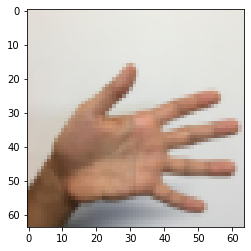

In [43]:
# Example of a picture
index = 0
plt.imshow(X_train_orig[index])
print ("y = " + str(np.squeeze(Y_train_orig[:, index])))

As usual you flatten the image dataset, then normalize it by dividing by 255. On top of that, you will convert each label to a one-hot vector as shown in Figure 1. Run the cell below to do so.

In [44]:
# Flatten the training and test images
X_train_flatten = X_train_orig.reshape(X_train_orig.shape[0], -1).T
X_test_flatten = X_test_orig.reshape(X_test_orig.shape[0], -1).T
# Normalize image vectors
X_train = X_train_flatten / 255.
X_test = X_test_flatten / 255.
# Convert training and test labels to one hot matrices
Y_train = convert_to_one_hot(Y_train_orig, 6)
Y_test = convert_to_one_hot(Y_test_orig, 6)

print("number of training examples = " + str(X_train.shape[1]))
print("number of test examples = " + str(X_test.shape[1]))
print("X_train shape: " + str(X_train.shape))
print("Y_train shape: " + str(Y_train.shape))
print("X_test shape: " + str(X_test.shape))
print("Y_test shape: " + str(Y_test.shape))

number of training examples = 1080
number of test examples = 120
X_train shape: (12288, 1080)
Y_train shape: (6, 1080)
X_test shape: (12288, 120)
Y_test shape: (6, 120)


**Note** that 12288 comes from $64 \times 64 \times 3$. Each image is square, 64 by 64 pixels, and 3 is for the RGB colors. Please make sure all these shapes make sense to you before continuing.

**Your goal** is to build an algorithm capable of recognizing a sign with high accuracy. To do so, you are going to build a tensorflow model that is almost the same as one you have previously built in numpy for cat recognition (but now using a softmax output). It is a great occasion to compare your numpy implementation to the tensorflow one. 

**The model** is *LINEAR -> RELU -> LINEAR -> RELU -> LINEAR -> SOFTMAX*. The SIGMOID output layer has been converted to a SOFTMAX. A SOFTMAX layer generalizes SIGMOID to when there are more than two classes. 

### 2.2 - Initializing the parameters

Your second task is to initialize the parameters in tensorflow.

**Exercise:** Implement the function below to initialize the parameters in tensorflow. You are going use Glorot Uniform Initialization for weights and Zero Initialization for biases. The shapes are given below. As an example, to help you, for W1 and b1 you could use: 

```python
W1 = tf.Variable(tf.initializers.glorot_uniform()((25, 12288)), name='W1')
b1 = tf.Variable(tf.initializers.zeros()((25, 1)), name='b1')
```
Please use `seed = 1` to make sure your results match ours.

In [47]:
# GRADED FUNCTION: initialize_parameters

def initialize_parameters():
    """
    Initializes parameters to build a neural network with tensorflow. The shapes are:
                        W1 : [25, 12288]
                        b1 : [25, 1]
                        W2 : [12, 25]
                        b2 : [12, 1]
                        W3 : [6, 12]
                        b3 : [6, 1]
    
    Returns:
    parameters -- a dictionary of tensors containing W1, b1, W2, b2, W3, b3
    """
    
    tf.random.set_seed(1)                   # so that your "random" numbers match ours
        
    ### START CODE HERE ### (approx. 6 lines of code)
    W1 = tf.Variable(tf.initializers.glorot_uniform()((25, 12288)), name='W1')
    b1 = tf.Variable(tf.initializers.zeros()((25, 1)), name='b1')
    W2 = tf.Variable(tf.initializers.glorot_uniform()((12, 25)), name='W2')
    b2 = tf.Variable(tf.initializers.zeros()((12, 1)), name='b2')
    W3 = tf.Variable(tf.initializers.glorot_uniform()((6, 12)), name='W3')
    b3 = tf.Variable(tf.initializers.zeros()((6, 1)), name='b3')
    ### END CODE HERE ###

    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2,
                  "W3": W3,
                  "b3": b3}
    
    return parameters

In [48]:
parameters = initialize_parameters()
print("W1 = " + str(parameters["W1"]))
print("b1 = " + str(parameters["b1"]))
print("W2 = " + str(parameters["W2"]))
print("b2 = " + str(parameters["b2"]))

W1 = <tf.Variable 'W1:0' shape=(25, 12288) dtype=float32, numpy=
array([[-1.47842336e-02,  1.77251101e-02,  5.78241609e-03, ...,
        -5.74509054e-03,  1.67791806e-02, -1.76099837e-02],
       [ 7.10822642e-05,  4.51281667e-04, -1.82342455e-02, ...,
         1.36572979e-02, -1.17452955e-02,  1.81304589e-02],
       [-1.38530191e-02, -8.04699305e-03, -5.75006939e-03, ...,
        -1.64859798e-02, -1.49659812e-03, -1.96594968e-02],
       ...,
       [ 1.79477036e-02, -1.62059460e-02,  1.37278400e-02, ...,
         1.88305639e-02, -4.04859334e-03,  8.19192454e-03],
       [ 3.84624675e-03, -1.64127555e-02, -1.21785151e-02, ...,
         1.00171529e-02,  4.27778065e-03,  5.20760752e-03],
       [-4.29783016e-04,  1.21666379e-02, -1.83665771e-02, ...,
        -2.16038935e-02,  1.55930333e-02, -1.61311366e-02]], dtype=float32)>
b1 = <tf.Variable 'b1:0' shape=(25, 1) dtype=float32, numpy=
array([[0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.

**Expected Output**: 

<table> 
    <tr> 
        <td>
            **W1**
        </td>
        <td>
         < tf.Variable 'W1:0' shape=(25, 12288) dtype=float32_ref >
        </td>
    </tr>
    <tr> 
        <td>
            **b1**
        </td>
        <td>
        < tf.Variable 'b1:0' shape=(25, 1) dtype=float32_ref >
        </td>
    </tr>
    <tr> 
        <td>
            **W2**
        </td>
        <td>
        < tf.Variable 'W2:0' shape=(12, 25) dtype=float32_ref >
        </td>
    </tr>
    <tr> 
        <td>
            **b2**
        </td>
        <td>
        < tf.Variable 'b2:0' shape=(12, 1) dtype=float32_ref >
        </td>
    </tr>

</table>

As expected, the parameters haven't been evaluated yet.

### 2.3 - Forward propagation in tensorflow 

You will now implement the forward propagation module in tensorflow. The function will take in a dictionary of parameters and it will complete the forward pass. The functions you will be using are: 

- `tf.add(...,...)` to do an addition
- `tf.matmul(...,...)` to do a matrix multiplication
- `tf.nn.relu(...)` to apply the ReLU activation

**Question:** Implement the forward pass of the neural network. We commented for you the numpy equivalents so that you can compare the tensorflow implementation to numpy. It is important to note that the forward propagation stops at `z3`. The reason is that in tensorflow the last linear layer output is given as input to the function computing the loss. Therefore, you don't need `a3`!



In [49]:
# GRADED FUNCTION: forward_propagation

def forward_propagation(X, parameters):
    """
    Implements the forward propagation for the model: LINEAR -> RELU -> LINEAR -> RELU -> LINEAR -> SOFTMAX
    
    Arguments:
    X -- input dataset, of shape (input size, number of examples)
    parameters -- python dictionary containing your parameters "W1", "b1", "W2", "b2", "W3", "b3"
                  the shapes are given in initialize_parameters

    Returns:
    Z3 -- the output of the last LINEAR unit
    """
    
    # Retrieve the parameters from the dictionary "parameters" 
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    W3 = parameters['W3']
    b3 = parameters['b3']
    
    ### START CODE HERE ### (approx. 5 lines)              # Numpy Equivalents:
    Z1 = tf.add(tf.matmul(W1, X), b1)                      # Z1 = np.dot(W1, X) + b1
    A1 = tf.nn.relu(Z1)                                    # A1 = relu(Z1)
    Z2 = tf.add(tf.matmul(W2, A1), b2)                     # Z2 = np.dot(W2, A1) + b2
    A2 = tf.nn.relu(Z2)                                    # A2 = relu(Z2)
    Z3 = tf.add(tf.matmul(W3, A2), b3)                     # Z3 = np.dot(W3,A2) + b3
    ### END CODE HERE ###
    
    return Z3

In [50]:
parameters = initialize_parameters()
Z3 = forward_propagation(X_train, parameters)
print("Z3 = " + str(Z3))

Z3 = tf.Tensor(
[[-0.11565053  0.09437902 -0.00375143 ... -0.02728732  0.06572004
  -0.02868922]
 [ 1.0180092   0.9685513   1.0115802  ...  1.2163582   1.0934578
   1.2193036 ]
 [-0.11545335 -0.19901218 -0.20647542 ... -0.3574288  -0.28355595
  -0.22626133]
 [-0.13243687 -0.00701094 -0.04400921 ...  0.03025216  0.13088915
  -0.00336176]
 [-0.6049128  -0.46807212 -0.659477   ... -0.39547634 -0.43241924
  -0.5847373 ]
 [ 0.74836224  1.0385891   0.7552044  ...  1.0284731   0.9370564
   0.97051334]], shape=(6, 1080), dtype=float32)


**Expected Output**: 

<table> 
    <tr> 
        <td>
            **Z3**
        </td>
        <td>
        Z3 = tf.Tensor([...], shape=(6, 1080), dtype=float32)
        </td>
    </tr>

</table>

You may have noticed that the forward propagation doesn't output any cache. You will understand why below, when we get to brackpropagation.

### 2.4 Compute cost

As seen before, it is very easy to compute the cost using:
```python
tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = ..., labels = ...))
```
**Question**: Implement the cost function below. 
- It is important to know that the "`logits`" and "`labels`" inputs of `tf.nn.softmax_cross_entropy_with_logits` are expected to be of shape (number of examples, num_classes). We have thus transposed Z3 and Y for you.
- Besides, `tf.reduce_mean` basically does the summation over the examples.

In [51]:
# GRADED FUNCTION: compute_cost 

def compute_cost(Z3, Y):
    """
    Computes the cost
    
    Arguments:
    Z3 -- output of forward propagation (output of the last LINEAR unit), of shape (6, number of examples)
    Y -- "true" labels vector placeholder, same shape as Z3
    
    Returns:
    cost - Tensor of the cost function
    """
    
    # to fit the tensorflow requirement for tf.nn.softmax_cross_entropy_with_logits(...,...)
    logits = tf.transpose(Z3)
    labels = tf.transpose(Y)
    
    ### START CODE HERE ### (1 line of code)
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=labels))
    ### END CODE HERE ###
    
    return cost

In [52]:
parameters = initialize_parameters()
Z3 = forward_propagation(X_test, parameters)
cost = compute_cost(Z3, Y_test)
print("cost = " + str(cost))

cost = tf.Tensor(1.9875417, shape=(), dtype=float32)


**Expected Output**: 

<table> 
    <tr> 
        <td>
            **cost**
        </td>
        <td>
        Tensor(1.9875417, shape=(), dtype=float32)
        </td>
    </tr>

</table>

### 2.5 - Backward propagation & parameter updates

This is where you become grateful to programming frameworks. All the backpropagation and the parameters update is taken care of in 1 line of code. It is very easy to incorporate this line in the model.

After you compute the cost function. You will create an "`optimizer`" object. When called, it will perform an optimization on the given cost with the chosen method and learning rate.

For instance, for gradient descent the optimizer would be:
```python
optimizer = tf.optimizers.Adam(learning_rate=learning_rate)
```

### 2.6 - Building the model

The beauty of TensorFlow 2 is in its simplicity. Basically, all you need to do is implement forward propagation through a computational graph. TensorFlow will compute the derivatives for you, by moving backwards through the graph recorded with `GradientTape`. All that's left for you to do then is specify the cost function and optimizer you want to use! 

When writing a TensorFlow program, the main object to get used and transformed is the `tf.Tensor`. These tensors are the TensorFlow equivalent of Numpy arrays, i.e. multidimensional arrays of a given data type that also contain information about the computational graph.

Below, you'll use `tf.Variable` to store the state of your variables. Variables can only be created once as its initial value defines the variable shape and type. Additionally, the `dtype` arg in `tf.Variable` can be set to allow data to be converted to that type. But if none is specified, either the datatype will be kept if the initial value is a Tensor, or `convert_to_tensor` will decide. It's generally best for you to specify directly, so nothing breaks!

Now, you will bring it all together! 

**Exercise:** Implement the model. You will be calling the functions you had previously implemented.

In [53]:
def model(X_train, Y_train, X_test, Y_test, learning_rate = 0.0001,
          num_epochs = 1500, minibatch_size = 32, print_cost = True):
    """
    Implements a three-layer tensorflow neural network: LINEAR->RELU->LINEAR->RELU->LINEAR->SOFTMAX.
    
    Arguments:
    X_train -- training set, of shape (input size = 12288, number of training examples = 1080)
    Y_train -- test set, of shape (output size = 6, number of training examples = 1080)
    X_test -- training set, of shape (input size = 12288, number of training examples = 120)
    Y_test -- test set, of shape (output size = 6, number of test examples = 120)
    learning_rate -- learning rate of the optimization
    num_epochs -- number of epochs of the optimization loop
    minibatch_size -- size of a minibatch
    print_cost -- True to print the cost every 100 epochs
    
    Returns:
    parameters -- parameters learnt by the model. They can then be used to predict.
    """
    
    tf.random.set_seed(1)                             # to keep consistent results
    seed = 3                                          # to keep consistent results
    (n_x, m) = X_train.shape                          # (n_x: input size, m : number of examples in the train set)
    n_y = Y_train.shape[0]                            # n_y : output size
    costs = []                                        # To keep track of the cost

    # Initialize parameters
    ### START CODE HERE ### (1 line)
    parameters = initialize_parameters()
    ### END CODE HERE ###

    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    W3 = parameters['W3']
    b3 = parameters['b3']
    
    # Backpropagation: Define the tensorflow optimizer. Use Adam optimizer.
    ### START CODE HERE ### (1 line)
    optimizer = tf.optimizers.Adam(learning_rate=learning_rate)
    ### END CODE HERE ###

    # Cost function
    ### START CODE HERE ### (1 line)
    def minibatch_cost(minibatch_X, parameters):
        # Forward propagation
        ### START CODE HERE ### (1 line)
        @tf.function
        def cost():
            Z3 = forward_propagation(minibatch_X, parameters)
            res = compute_cost(Z3, minibatch_Y)
            return res
        return cost
        ### END CODE HERE ###
    # minibatch_cost = compute_cost(Z3, minibatch_Y)
    ### END CODE HERE ###
        
    # Do the training loop
    for epoch in range(num_epochs):

        epoch_cost = 0.                       # Defines a cost related to an epoch
        num_minibatches = int(m / minibatch_size) # number of minibatches of size minibatch_size in the train set
        seed = seed + 1
        minibatches = random_mini_batches(X_train, Y_train, minibatch_size, seed)

        for minibatch in minibatches:

            # Select a minibatch
            (minibatch_X, minibatch_Y) = minibatch

            # train the model on a minibatch.
            ### START CODE HERE ### (1 line)
            with tf.GradientTape() as tape:
                # 1. predict
                Z3 = forward_propagation(minibatch_X, parameters)
                # 2. loss
                minibatch_cost = compute_cost(Z3, minibatch_Y)
            
            trainable_variables = [W1, b1, W2, b2, W3, b3]
            grads = tape.gradient(minibatch_cost, trainable_variables)
            optimizer.apply_gradients(zip(grads, trainable_variables))
            ### END CODE HERE ###

            epoch_cost += minibatch_cost / num_minibatches

        # Print the cost every epoch
        if print_cost == True and epoch % 100 == 0:
            print ("Cost after epoch %i: %f" % (epoch, epoch_cost))
        if print_cost == True and epoch % 5 == 0:
            costs.append(epoch_cost)
            
    # plot the cost
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per tens)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()

    # # Calculate the correct predictions
    # correct_prediction = tf.equal(tf.argmax(Z3), tf.argmax(Y))

    # # Calculate accuracy on the test set
    # accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))

    # print("Train Accuracy:", accuracy.eval({X: X_train, Y: Y_train}))
    # print("Test Accuracy:", accuracy.eval({X: X_test, Y: Y_test}))
    
    return parameters

Run the following cell to train your model! On our machine it takes about 5 minutes. Your "Cost after epoch 100" should be 1.016458. If it's not, don't waste time; interrupt the training by clicking on the square (⬛) in the upper bar of the notebook, and try to correct your code. If it is the correct cost, take a break and come back in 5 minutes!

In [ ]:
parameters = model(X_train, Y_train, X_test, Y_test)

**Expected Output**:

<table> 
    <tr> 
        <td>
            **Train Accuracy**
        </td>
        <td>
        0.999074
        </td>
    </tr>
    <tr> 
        <td>
            **Test Accuracy**
        </td>
        <td>
        0.716667
        </td>
    </tr>

</table>

Amazing, your algorithm can recognize a sign representing a figure between 0 and 5 with 71.7% accuracy.

**Insights**:
- Your model seems big enough to fit the training set well. However, given the difference between train and test accuracy, you could try to add L2 or dropout regularization to reduce overfitting. 
- Think about the session as a block of code to train the model. Each time you run the session on a minibatch, it trains the parameters. In total you have run the session a large number of times (1500 epochs) until you obtained well trained parameters.

### 2.7 - Test with your own image (optional / ungraded exercise)

Congratulations on finishing this assignment. You can now take a picture of your hand and see the output of your model. To do that:
    1. Click on "File" in the upper bar of this notebook, then click "Open" to go on your Coursera Hub.
    2. Add your image to this Jupyter Notebook's directory, in the "images" folder
    3. Write your image's name in the following code
    4. Run the code and check if the algorithm is right!

In [ ]:
import scipy
from PIL import Image
from scipy import ndimage

## START CODE HERE ## (PUT YOUR IMAGE NAME) 
my_image = "thumbs_up.jpg"
## END CODE HERE ##

# We preprocess your image to fit your algorithm.
fname = "images/" + my_image
image = np.array(ndimage.imread(fname, flatten=False))
my_image = scipy.misc.imresize(image, size=(64, 64)).reshape((1, 64 * 64 * 3)).T
my_image_prediction = predict(my_image, parameters)

plt.imshow(image)
print("Your algorithm predicts: y = " + str(np.squeeze(my_image_prediction)))

You indeed deserved a "thumbs-up" although as you can see the algorithm seems to classify it incorrectly. The reason is that the training set doesn't contain any "thumbs-up", so the model doesn't know how to deal with it! We call that a "mismatched data distribution" and it is one of the various of the next course on "Structuring Machine Learning Projects".

<font color='blue'>
**What you should remember**:
- Tensorflow is a programming framework used in deep learning
- The two main object classes in tensorflow are Tensors and Operators. 
- When you code in tensorflow you have to take the following steps:
    - Create a graph containing Tensors (Variables, Placeholders ...) and Operations (tf.matmul, tf.add, ...)
    - Create a session
    - Initialize the session
    - Run the session to execute the graph
- You can execute the graph multiple times as you've seen in model()
- The backpropagation and optimization is automatically done when running the session on the "optimizer" object.